#### Importing the required packages

In [45]:
from __future__ import print_function, division

import pandas as pd
import os
import shutil

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

#### Importing and storing the train and test files

In [1]:
# Importing the train file and renaming columns
train_file_path = '95-891-hw3/HW3_train.csv'
train_data = pd.read_csv(train_file_path, header = None)
train_data.columns = ['columns_id', 'url', 'landmark_id']

# Creating a dictionary for storing image identifier and landmark identifier
train_image_names = train_data['columns_id']
train_image_labels = train_data['landmark_id']
train_image_names_list = train_image_names.to_list()
train_image_labels_list = train_image_labels.to_list()
train_data_dict = dict(zip(train_image_names_list, train_image_labels_list))

# Importing the train file and renaming columns
test_file_path = '95-891-hw3/HW3_test.csv'
test_data = pd.read_csv(test_file_path, header = None)
test_data.columns = ['columns_id', 'url', 'landmark_id']

# Creating a dictionary for storing image identifier and landmark identifier
test_image_names = test_data['columns_id']
test_image_labels = test_data['landmark_id']
test_image_names_list = test_image_names.to_list()
test_image_labels_list = test_image_labels.to_list()
test_data_dict = dict(zip(test_image_names_list, test_image_labels_list))

#### Identifying and storing the train images

In [9]:
all_images_folder_path = "95-891-hw3/images"
train_destination_folder = "images1/train"

all_files = os.listdir(all_images_folder_path)

for image_all in all_files:
    for image_train in train_data_dict.keys():
        if image_all.strip().startswith(image_train.strip()):
            full_path_to_file = all_images_folder_path + '/' + image_all.strip()
            train_destination_path = train_destination_folder + '/' + str(train_data_dict[image_train])
            shutil.copy(full_path_to_file, train_destination_path)

#### Identifying and storing the validation images

In [11]:
test_destination_folder = "images1/val"

for image_all in all_files:
    for image_test in test_data_dict.keys():
        if image_all.strip().startswith(image_test.strip()):
            full_path_to_file = all_images_folder_path + '/' + image_all.strip()
            test_destination_path = test_destination_folder + '/' + str(test_data_dict[image_test])
            shutil.copy(full_path_to_file, test_destination_path)

#### Loading the normalizing the data

In [46]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'images1'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=30,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Function for training the model

In [47]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

#### Loading the pretrained resnet18 model

In [48]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

#### Calling the function to train the model

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

#### Saving the model object to a file

In [34]:
torch.save(model_conv, "full_landmark_model.pt")

#### Loading the model from the file

In [49]:
model_full = torch.load('full_landmark_model.pt', map_location=torch.device('cpu'))

#### Computing the confusion matrix on validation data

In [50]:
nb_classes = 10

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_full(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[325.,   0.,   3.,   5.,   1.,   0.,   2.,   0.,   1.,   4.],
        [  0., 383.,   0.,   0.,   1.,   0.,   0.,   5.,   2.,   1.],
        [  2.,   1., 324.,   8.,   8.,   0.,   6.,   3.,   3.,   6.],
        [ 13.,   0.,   3., 303.,   3.,   0.,   6.,   3.,   3.,   5.],
        [  3.,   1.,   6.,   1., 303.,   0.,   6.,  19.,   5.,   1.],
        [  0.,   2.,   2.,   0.,   1., 327.,   2.,   1.,   1.,   1.],
        [  0.,   0.,   1.,   3.,   9.,   0., 276.,   9.,   2.,   9.],
        [  0.,   1.,   4.,   0.,  19.,   1.,   9., 275.,   6.,   1.],
        [  2.,   3.,   1.,   9.,  26.,   1.,   5.,  15., 268.,   2.],
        [  1.,   0.,   1.,   3.,   0.,   2.,   1.,   0.,   1., 236.]])


#### Normalized confusion matrix

In [60]:
normalized_confusion_matrix = confusion_matrix/confusion_matrix.sum(0)
print(normalized_confusion_matrix)

tensor([[0.9393, 0.0000, 0.0087, 0.0151, 0.0027, 0.0000, 0.0064, 0.0000, 0.0034,
         0.0150],
        [0.0000, 0.9795, 0.0000, 0.0000, 0.0027, 0.0000, 0.0000, 0.0152, 0.0068,
         0.0038],
        [0.0058, 0.0026, 0.9391, 0.0241, 0.0216, 0.0000, 0.0192, 0.0091, 0.0103,
         0.0226],
        [0.0376, 0.0000, 0.0087, 0.9127, 0.0081, 0.0000, 0.0192, 0.0091, 0.0103,
         0.0188],
        [0.0087, 0.0026, 0.0174, 0.0030, 0.8167, 0.0000, 0.0192, 0.0576, 0.0171,
         0.0038],
        [0.0000, 0.0051, 0.0058, 0.0000, 0.0027, 0.9879, 0.0064, 0.0030, 0.0034,
         0.0038],
        [0.0000, 0.0000, 0.0029, 0.0090, 0.0243, 0.0000, 0.8818, 0.0273, 0.0068,
         0.0338],
        [0.0000, 0.0026, 0.0116, 0.0000, 0.0512, 0.0030, 0.0288, 0.8333, 0.0205,
         0.0038],
        [0.0058, 0.0077, 0.0029, 0.0271, 0.0701, 0.0030, 0.0160, 0.0455, 0.9178,
         0.0075],
        [0.0029, 0.0000, 0.0029, 0.0090, 0.0000, 0.0060, 0.0032, 0.0000, 0.0034,
         0.8872]])


#### Test accuracy

In [53]:
print('Test accuracy:',(confusion_matrix.diag().sum()/confusion_matrix.sum()).tolist())

Test accuracy: 0.9104612469673157


#### Calculating the precision

In [55]:
# Precision = TP / (TP + FP)
precision_list = []
for i in range(len(confusion_matrix)):
    true_positive = confusion_matrix[i][i]
    false_positive = 0
    for j in range(len(confusion_matrix)):
        if i != j:
            false_positive += confusion_matrix[j][i]
    precision = true_positive / (true_positive + false_positive)
    precision_list.append(precision.tolist())

landmarks = list(range(10))
precision_df = pd.DataFrame(
    {'landmarks id': landmarks,
     'precision': precision_list,
    })
precision_df

,landmarks id,precision
0,0,0.939306
1,1,0.979540
2,2,0.939130
3,3,0.912651
4,4,0.816712
5,5,0.987915
6,6,0.881789
7,7,0.833333
8,8,0.917808
9,9,0.887218


#### Calculating the recall

In [56]:
# Recall = TP / (TP + FN)
recall_list = []
for i in range(len(confusion_matrix)):
    true_positive = confusion_matrix[i][i]
    false_negative = confusion_matrix[i].sum() - confusion_matrix[i][i]
    recall = true_positive / (true_positive + false_negative)
    recall_list.append(recall.tolist())

landmarks = list(range(10))
recall_df = pd.DataFrame(
    {'landmarks id': landmarks,
     'recall': recall_list,
    })
recall_df

,landmarks id,recall
0,0,0.953079
1,1,0.977041
2,2,0.897507
3,3,0.893805
4,4,0.878261
5,5,0.970326
6,6,0.893204
7,7,0.870253
8,8,0.807229
9,9,0.963265


#### Plot the precision and recall values

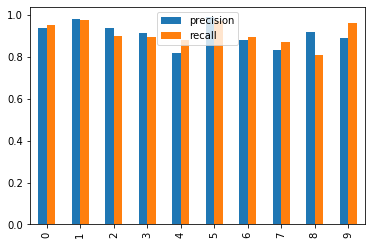

In [57]:
pr = pd.DataFrame(
    {'precision': precision_list,
     'recall': recall_list,
    })
pr.plot.bar()

#### References
- https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

#### Note
- The model was trained on Collab and saved in a file. This model file was then loaded in the notebook on local to get the required metrics.